In [1]:
import gsw
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mocsy import mocsy
import cmocean.cm as cm
import pandas as pd
from salishsea_tools import viz_tools

## Make mask for coastline points

In [2]:
# open the mesh mask and use it to mask the land
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

# get the bathymetry file
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

(0.0, 898.0)

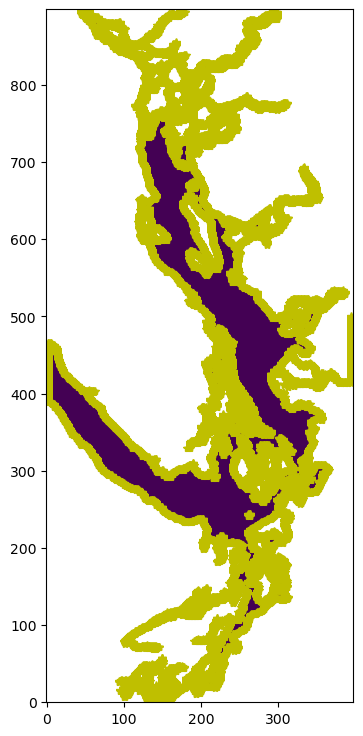

In [15]:
depth_idx = 5
mesh_masked = np.ma.masked_array(tmask[depth_idx, :, :], mask=tmask[depth_idx, :, :])

## This one finds the land coastal points
array = np.array(1 - tmask[depth_idx])

# Calculate the differences along the specified axis in specific direction
diffs_up = array - np.roll(array, 1, axis=0)
diffs_down = array - np.roll(array, -1, axis=0)
diffs_left = array - np.roll(array, 1, axis=1)
diffs_right = array - np.roll(array, -1, axis=1)

diffs_ul = array - np.roll(np.roll(array, 1, axis=0), 1, axis=1)
diffs_ur = array - np.roll(np.roll(array, 1, axis=0), -1, axis=1)
diffs_ll = array - np.roll(np.roll(array, -1, axis=0), 1, axis=1)
diffs_lr = array - np.roll(np.roll(array, -1, axis=0), -1, axis=1)

# Find the indices where transitions occur from land to water
idx_up = np.argwhere(diffs_up == 1)
idx_down = np.argwhere(diffs_down == 1)
idx_left = np.argwhere(diffs_left == 1)
idx_right = np.argwhere(diffs_right == 1)

idx_ul = np.argwhere(diffs_ul == 1)
idx_ur = np.argwhere(diffs_ur == 1)
idx_ll = np.argwhere(diffs_ll == 1)
idx_lr = np.argwhere(diffs_lr == 1)

idx_unique = np.unique(np.concatenate((idx_up, idx_down, idx_left, idx_right, idx_ul, idx_ur, idx_ll, idx_lr)), axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
ax.imshow(mesh_masked)

ax.plot(idx_unique[1], idx_unique[0], 'y*')

ax.set_ylim([0,898])
# ax.set_xlim([280, 320])
# ax.set_ylim([480, 520])

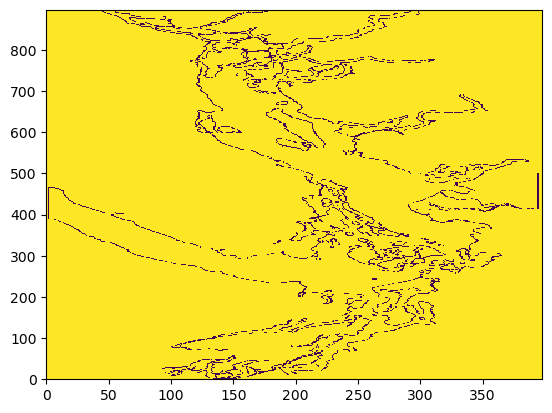

In [16]:
blank = np.zeros(mesh_masked.shape)
blank[idx_unique[0], idx_unique[1]] = 1
coastline = 1 - blank
plt.pcolormesh(coastline)

In [17]:
np.savetxt('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/stair_collab/{}.nc'.format('coastline_5m'), coastline, delimiter=',')

## Calculations

In [5]:
year = 2023
chem_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_chem_00_05_20230101_20231231.nc')
phys_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_phys_00_05_20230101_20231231.nc')

In [6]:
chem_mon = chem_day.resample(time='1M').mean()
phys_mon = phys_day.resample(time='1M').mean()

In [35]:
phys_mon

<xarray.Dataset>
Dimensions:   (depth: 5, gridY: 898, gridX: 398, time: 12)
Coordinates:
  * depth     (depth) float32 0.5 1.5 2.5 3.5 4.5
  * gridY     (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX     (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * time      (time) datetime64[ns] 2023-01-31 2023-02-28 ... 2023-12-31
Data variables:
    votemper  (time, depth, gridY, gridX) float32 nan nan nan ... nan nan nan
    vosaline  (time, depth, gridY, gridX) float32 nan nan nan ... nan nan nan
Attributes:
    name:         SalishSeaCast_day_avg_phys_00_05_20230101_20231231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2024-04-04 13:10 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

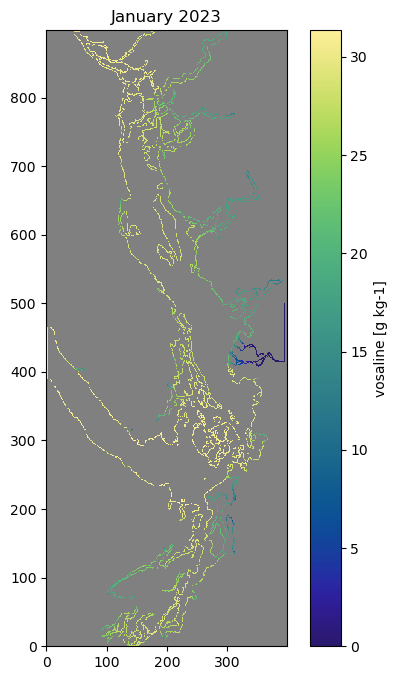

In [7]:
nrow = 1
ncol = 1
idepth = 0
jdepth = 0
p_var = 'vosaline'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (6, 8), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(phys_mon[p_var][time_idx, idepth], mask=coastline)
        colours = ax.pcolormesh(salinity, vmin=0, cmap=cmap)
        dtime = pd.to_datetime(phys_mon['time'].values[time_idx])
        ax.set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, phys_mon[p_var].units))

In [8]:
nrow = 3
ncol = 4

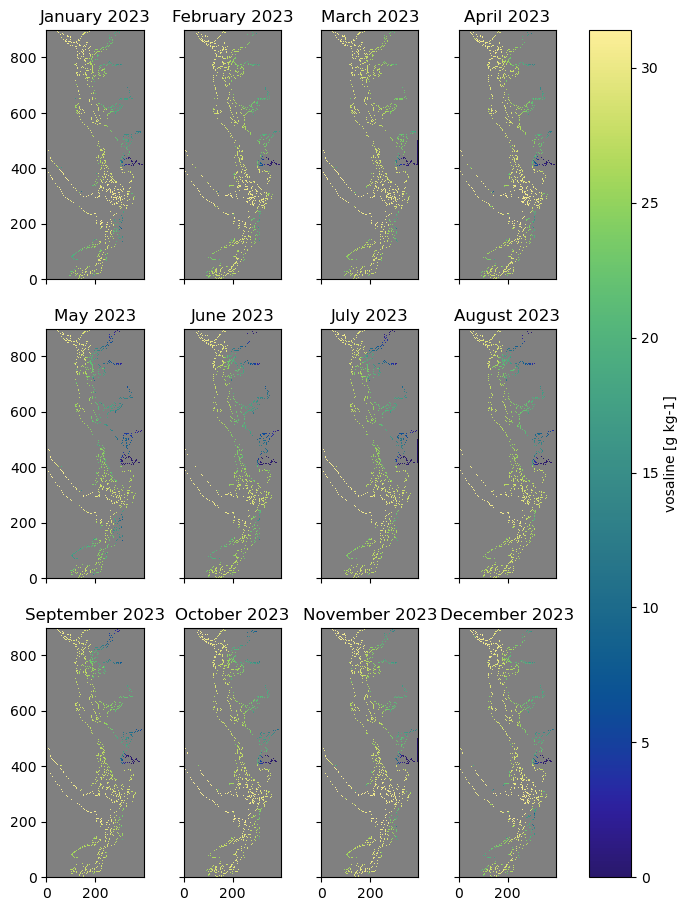

In [9]:
idepth = 0
jdepth = 0
p_var = 'vosaline'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(phys_mon[p_var][time_idx, idepth], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
        dtime = pd.to_datetime(phys_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, phys_mon[p_var].units))

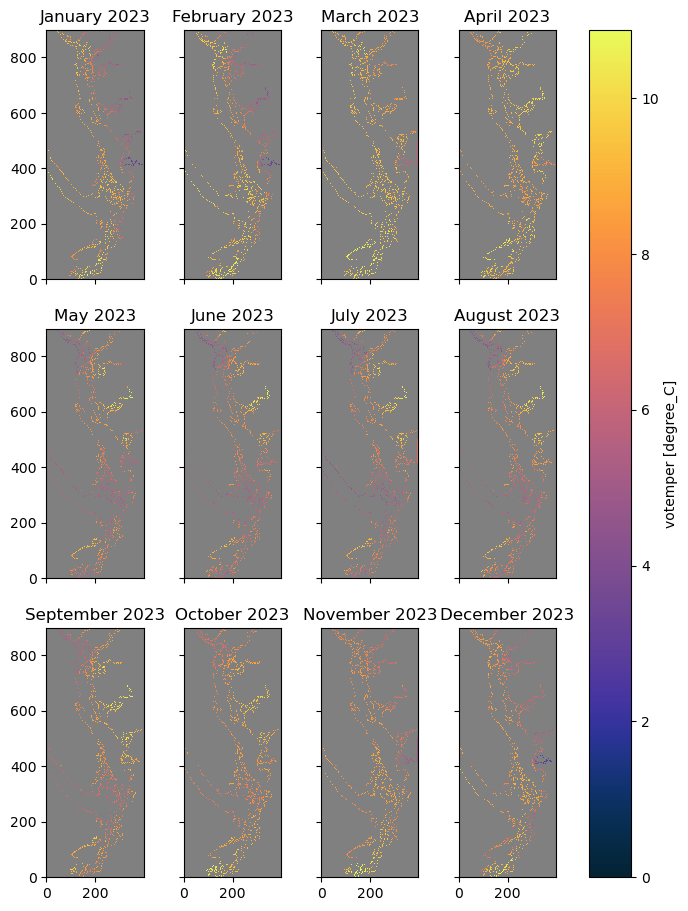

In [10]:
idepth = 0
jdepth = 0
p_var = 'votemper'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.thermal
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(phys_mon[p_var][time_idx, idepth], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
        dtime = pd.to_datetime(phys_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, phys_mon[p_var].units))

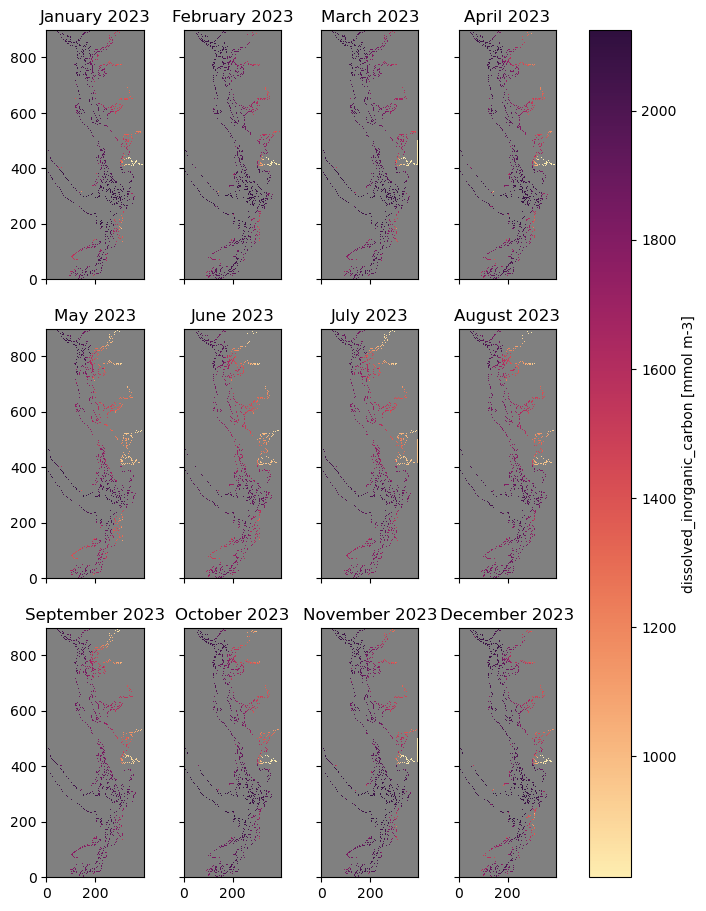

In [11]:
idepth = 0
jdepth = 0
p_var = 'dissolved_inorganic_carbon'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.matter
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(chem_mon[p_var][time_idx, idepth], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, cmap=cmap)
        dtime = pd.to_datetime(chem_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, chem_mon[p_var].units))

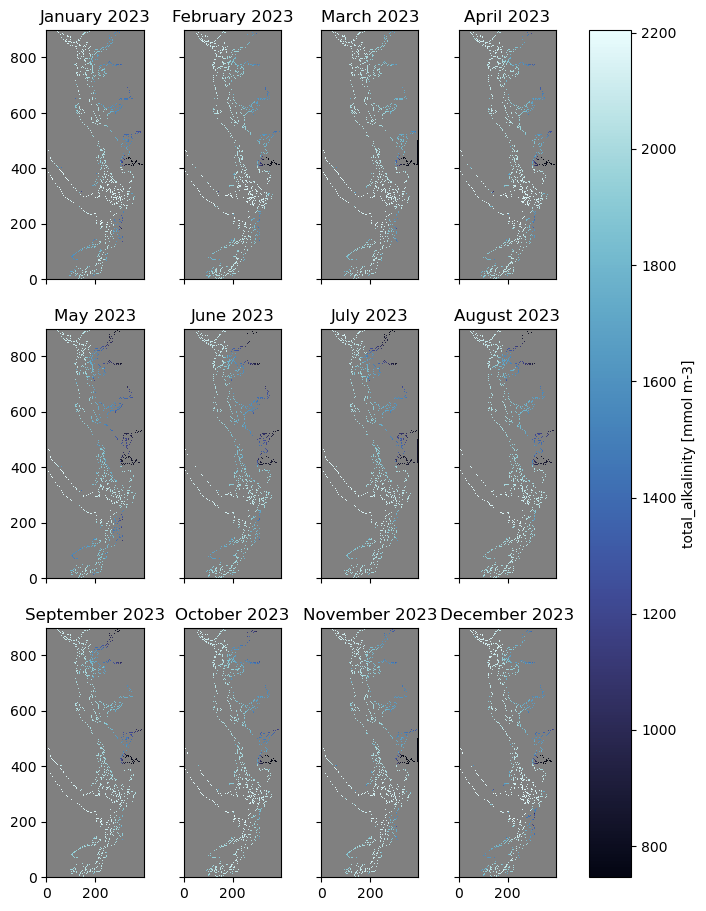

In [12]:
idepth = 0
jdepth = 0
p_var = 'total_alkalinity'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.ice
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(chem_mon[p_var][time_idx, idepth], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, cmap=cmap)
        dtime = pd.to_datetime(chem_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, chem_mon[p_var].units))

In [13]:
def mocsy_simp(ii, ij, ji, jj, idepth, phys_ds, chem_ds):
    Tinsitu = np.array(gsw.t_from_CT(phys_ds.vosaline[idepth, ii:ij, ji:jj], phys_ds.votemper[idepth,  ii:ij, ji:jj], 0))
    Spsu = 35/35.16504 * np.array(phys_ds.vosaline[idepth,  ii:ij, ji:jj])
    TA = np.array(chem_ds.total_alkalinity[idepth,  ii:ij, ji:jj])/1000.
    DIC = np.array(chem_ds.dissolved_inorganic_carbon[idepth,  ii:ij, ji:jj])/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH.reshape([ij-ii, jj-ji]), OmegaA.reshape([ij-ii, jj-ji])

In [14]:
phys_mon.isel(time=0)

<xarray.Dataset>
Dimensions:   (depth: 5, gridY: 898, gridX: 398)
Coordinates:
  * depth     (depth) float32 0.5 1.5 2.5 3.5 4.5
  * gridY     (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX     (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
    time      datetime64[ns] 2023-01-31
Data variables:
    votemper  (depth, gridY, gridX) float32 nan nan nan nan ... nan nan nan nan
    vosaline  (depth, gridY, gridX) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    name:         SalishSeaCast_day_avg_phys_00_05_20230101_20231231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2024-04-04 13:10 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [15]:
pH_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)

In [16]:
pH_mon

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
idepth = 4
ii, ij = 0, 898
ji, jj = 0, 398

pH_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)
OmegaA_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)

for time_idx in np.arange(len(phys_mon['time'])):
        print(time_idx)
        pH, OmegaA = mocsy_simp(ii, ij, ji, jj, idepth, phys_mon.isel(time=time_idx), chem_mon.isel(time=time_idx))
        print(pH.shape)
        pH_mon[time_idx] = pH
        OmegaA_mon[time_idx] = OmegaA

0
(898, 398)
1
(898, 398)
2
(898, 398)
3
(898, 398)
4
(898, 398)
5
(898, 398)
6
(898, 398)
7
(898, 398)
8
(898, 398)
9
(898, 398)
10
(898, 398)
11
(898, 398)


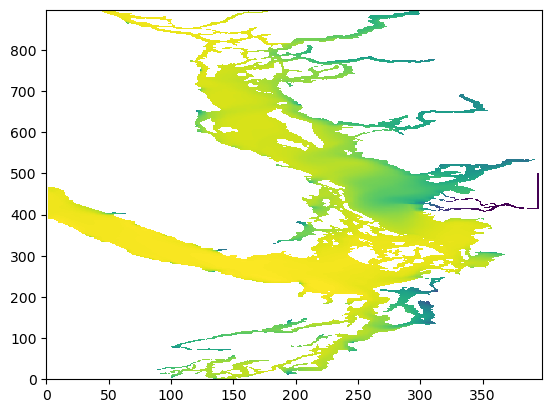

In [18]:
test = np.ma.masked_array(phys_mon['vosaline'][0][0], mask=tmask[0])
plt.pcolormesh(test)

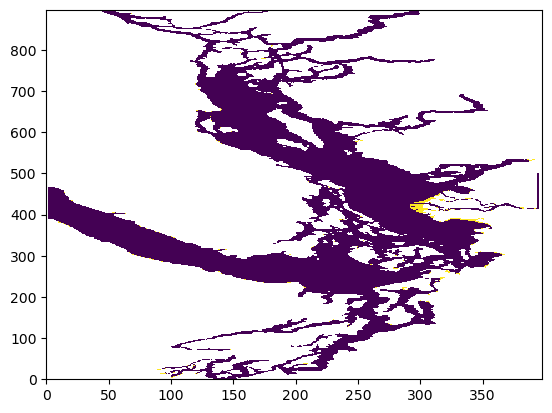

In [19]:
test = np.ma.masked_array(pH_mon[0], mask=tmask[0])
plt.pcolormesh(test)

In [20]:
pH_mon.shape
12 * 898 * 398

4288848

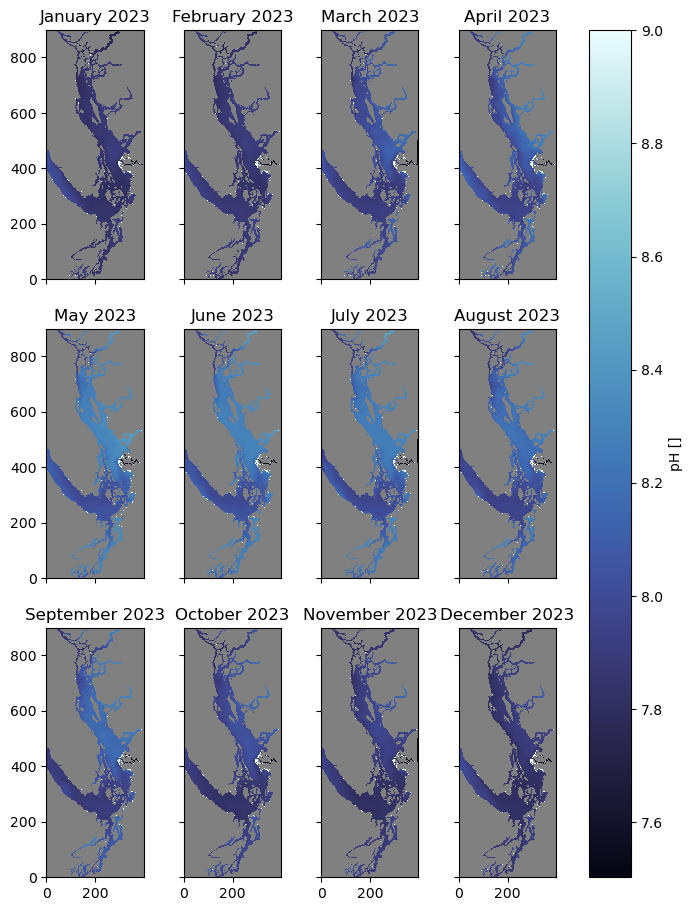

In [21]:
idepth = 4
ii, ij = 0, 898
ji, jj = 0, 398
p_var = 'pH'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.ice
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(pH_mon[time_idx], mask=tmask[0])
        # salinity = np.ma.masked_array(pH_mon[time_idx], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, vmax=9, cmap=cmap)
        dtime = pd.to_datetime(chem_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, ''))

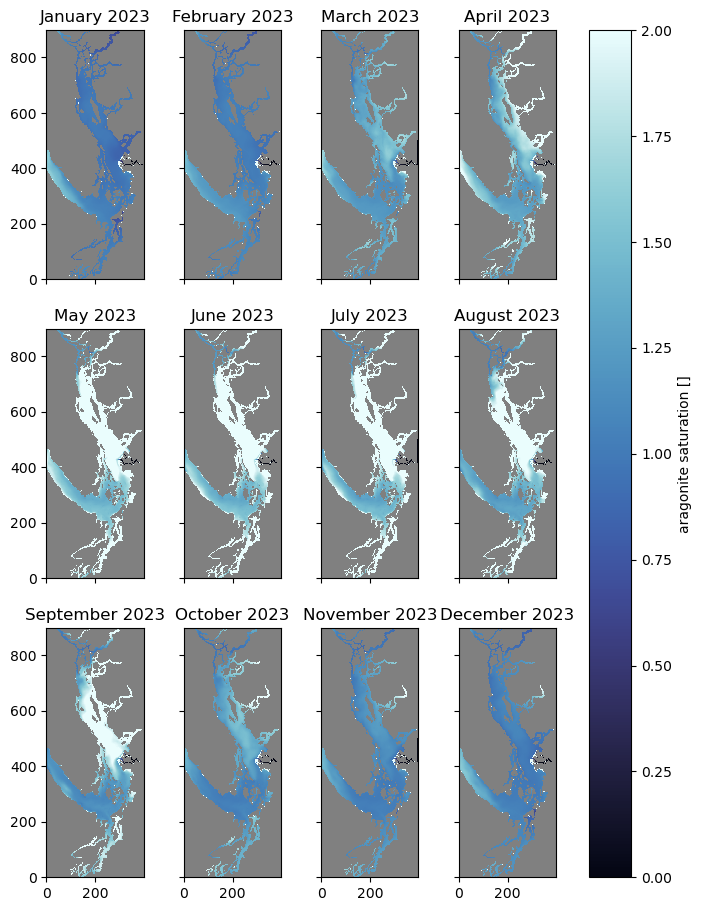

In [22]:
idepth = 4
ii, ij = 0, 898
ji, jj = 0, 398
p_var = 'aragonite saturation'
fname = '{}_all_domain_subset_daily_i{}_j{}_y{}'.format(p_var, idepth, jdepth, year)
cmap = cm.ice
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(OmegaA_mon[time_idx], mask=tmask[0])
        # salinity = np.ma.masked_array(OmegaA_mon[time_idx], mask=coastline)
        colours = ax[row,col].pcolormesh(salinity, vmax=2, cmap=cmap)
        dtime = pd.to_datetime(chem_mon['time'].values[time_idx])
        ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, ''))

In [23]:
ii, ij = 0, 898
ji, jj = 0, 398

idepth = 4

In [24]:
Tinsitu = np.array(gsw.t_from_CT(phys_mon.vosaline[0, idepth, ii:ij, ji:jj], phys_mon.votemper[0, idepth,  ii:ij, ji:jj], 0))

In [25]:
Spsu = 35/35.16504 * np.array(phys_mon.vosaline[0, idepth,  ii:ij, ji:jj])

In [26]:
TA = np.array(chem_mon.total_alkalinity[0, idepth,  ii:ij, ji:jj])/1000.
DIC = np.array(chem_mon.dissolved_inorganic_carbon[0, idepth,  ii:ij, ji:jj])/1000.

In [27]:
ones = np.ones_like(Spsu.flatten())

In [28]:
response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

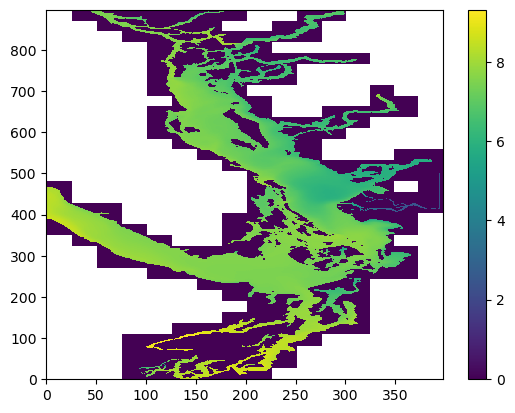

In [29]:
#plt.plot(Tis, 'x')
#plt.plot(pH, 'o')
#plt.plot(OmegaA, 'P')
#plt.plot(co2, 'o')
mymask = Tinsitu == Tinsitu[-1, 0];
ma = np.ma.array(Tinsitu, mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();

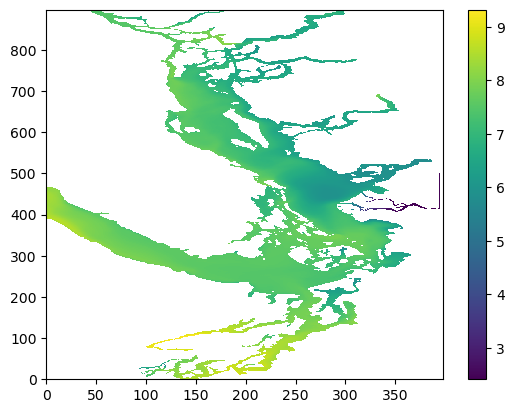

In [30]:
mymask = Tis.reshape([ij-ii, jj-ji]) > 100;
ma = np.ma.array(Tis.reshape([ij-ii, jj-ji]), mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();

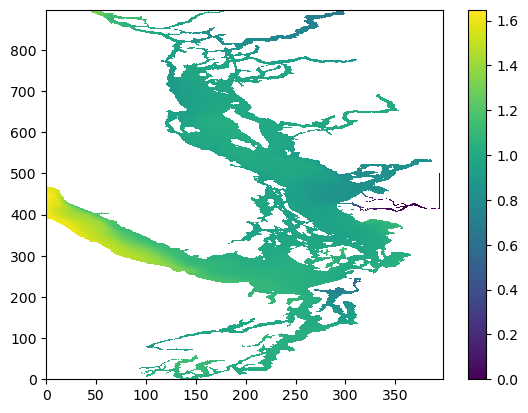

In [31]:
mymask = OmegaA.reshape([ij-ii, jj-ji]) > 100;
ma = np.ma.array(OmegaA.reshape([ij-ii, jj-ji]), mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();

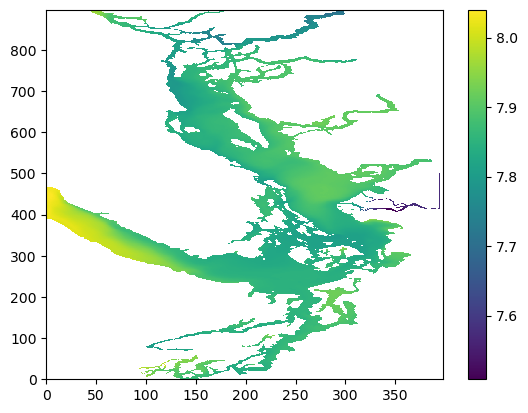

In [32]:
mymask = pH.reshape([ij-ii, jj-ji]) > 100;
ma = np.ma.array(pH.reshape([ij-ii, jj-ji]), mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();

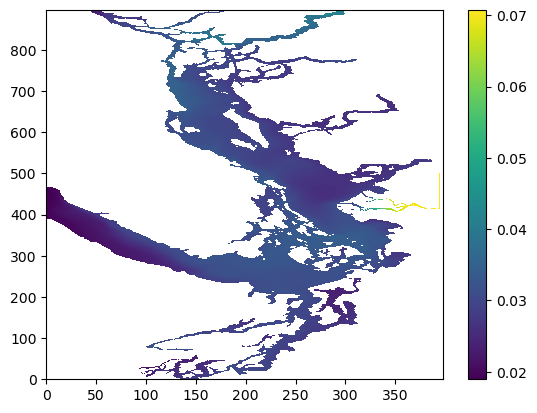

In [33]:
mymask = co2.reshape([ij-ii, jj-ji]) > 100;
ma = np.ma.array(co2.reshape([ij-ii, jj-ji]), mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();

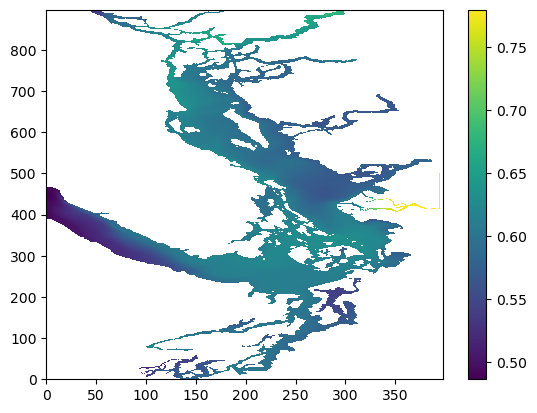

In [34]:
mymask = co2.reshape([ij-ii, jj-ji]) > 100;
ma = np.ma.array(co2.reshape([ij-ii, jj-ji]) / 
                 (0.02+co2.reshape([ij-ii, jj-ji])), mask=mymask)
plt.pcolormesh(ma);
plt.colorbar();